# 0. Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. Load Data
- 호연이 형 전처리 데이터 + 정상 데이터 3개 합쳐둔 csv

In [20]:
data = pd.read_csv('/content/drive/MyDrive/KAMP/data/rate_zero_more.csv', header=None)

In [21]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,27.8645,99.6709,100.0340,69.6122,48.3653,48.9108,0.450569,859.518,859.896,859.787,860.029,278.475,284.534,329.164
1,25.3182,99.6709,99.9727,69.6122,48.3572,48.9786,0.450856,859.767,859.896,859.787,860.091,278.537,284.595,329.225
2,25.3030,99.6709,100.0340,69.6736,48.4052,49.0409,0.451001,859.767,859.896,859.787,860.091,278.475,284.534,329.225
3,25.2896,99.6709,100.0340,69.6736,46.8729,49.0980,0.451201,859.767,859.958,859.787,860.091,278.475,284.534,329.225
4,25.2778,99.6709,100.0340,69.6122,46.8696,49.0629,0.451377,859.767,859.960,859.791,860.097,278.425,284.486,329.174


# 2. Pre-Process Data
- 최대한 같은 배정번호끼리 묶고 싶어서 train, test split 할 때, shuffle = false로 진행
  - 어차피 완전히 새로운 데이터가 들어온다고 했을 때도, shuffle 돼서 들어오지 않기 때문에 괜찮다고 생각함.

In [22]:
# 데이터 정규화
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data)

# 데이터 정규화 X(# 데이터 형태만 변경)
data_ndarray = data.values

# 데이터 분할
x_train, x_test = train_test_split(data_ndarray, test_size=0.2, random_state=42, shuffle=False)

# 3. Model

## 3.1 Data Loader
- 위와 동일한 이유로 batch split을 shuffle = false로 진행

In [24]:
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

## 3.2 Create Model

In [25]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(input_dim // 4, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [26]:
model = AutoEncoder(input_dim=x_train.shape[1])

In [27]:
# 손실함수 MSE, 옵티마이저 Adam, 학습률 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 3.3 Train Model

In [28]:
epochs = 100

patience = 10
best_loss = np.inf
early_stop_counter = 0

loss_history = []

for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        inputs, = batch
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_history.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

    # Early stopping 체크
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), '/content/drive/MyDrive/KAMP/model/best_model.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping")
            break

Epoch 1/100, Loss: 58957.3671875
Epoch 2/100, Loss: 58953.2578125
Epoch 3/100, Loss: 58952.578125
Epoch 4/100, Loss: 58952.46875
Epoch 5/100, Loss: 58952.60546875
Epoch 6/100, Loss: 58952.41015625
Epoch 7/100, Loss: 58952.41015625
Epoch 8/100, Loss: 58952.3984375
Epoch 9/100, Loss: 58952.46484375
Epoch 10/100, Loss: 58952.40625
Epoch 11/100, Loss: 58952.40625
Epoch 12/100, Loss: 58952.41796875
Epoch 13/100, Loss: 58952.4296875
Epoch 14/100, Loss: 58952.421875
Epoch 15/100, Loss: 58952.41796875
Epoch 16/100, Loss: 58952.41796875
Epoch 17/100, Loss: 58952.41796875
Epoch 18/100, Loss: 58952.421875
Early stopping


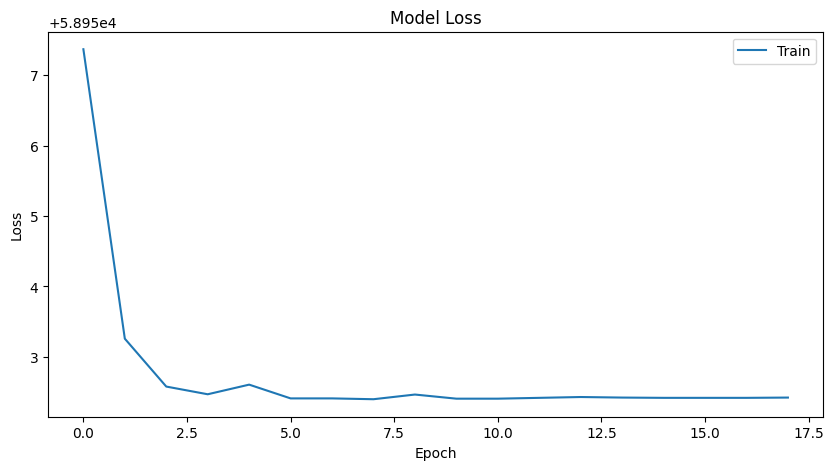

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

# 4. Evaluate Model

## 4.1 Test Data
- anomaly score 계산

In [30]:
model.load_state_dict(torch.load('/content/drive/MyDrive/KAMP/model/best_model.pth'))
model.eval()
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    predictions = model(x_test_tensor)
    mse = mean_squared_error(x_test, predictions.numpy())
    print(f'MSE: {mse}')

MSE: 59549.12647762427


## 4.2 Anomaly Data
- 배정번호 140920 데이터
    - 정상 60,170 / 불량 120
- anomaly score 계산

In [31]:
# 4.3.1 Load Data
anomaly_data = pd.read_csv('/content/drive/MyDrive/KAMP/data/anomaly_data_140920.csv')

# 4.3.2 Pre-process Data
# anomaly_data_scaled = scaler.fit_transform(anomaly_data)
anomaly_data_scaled = anomaly_data.values

# 4.3.3 Evaluate
model.load_state_dict(torch.load('/content/drive/MyDrive/KAMP/model/best_model.pth'))
model.eval()
with torch.no_grad():
    anomaly_data_scaled_tensor = torch.tensor(anomaly_data_scaled, dtype=torch.float32)
    predictions = model(anomaly_data_scaled_tensor)
    mse = mean_squared_error(anomaly_data_scaled, predictions.numpy())
    print(f'MSE: {mse}')

MSE: 59484.18864919733


## 4.3 Almost Normal Data
- 배정번호 142324 데이터
    - 정상 18,127 / 불량 1
- anomaly score 계산
- 정상 데이터를 모두 학습에 활용해서, 학습에 사용되지 않은 데이터 중 가장 정상에 가까운 데이터 사용

In [32]:
# 4.3.1 Load Data
almost_normal_data = pd.read_csv('/content/drive/MyDrive/KAMP/data/almost_normal_data_142324.csv')

# 4.3.2 Pre-process  Data
almost_normal_data_scaled = almost_normal_data.values

# 4.3.3 Evaluate
model.load_state_dict(torch.load('/content/drive/MyDrive/KAMP/model/best_model.pth'))
model.eval()
with torch.no_grad():
    almost_normal_data_scaled_tensor = torch.tensor(almost_normal_data_scaled, dtype=torch.float32)
    predictions = model(almost_normal_data_scaled_tensor)
    mse = mean_squared_error(almost_normal_data_scaled, predictions.numpy())
    print(f'MSE: {mse}')

MSE: 59455.563494714035


# 5. Appendix

- Shuffle=False에 대한 근거
  1. 성능 비교해본 결과, Shffle =True보다 더 낮은 Test MSE를 보였고, Anomaly Data와 더 큰 MSE 차이를 보였다.
    - True일 때, Test : 0.788 / Anomaly : 0.856 -> 0.68 차이
  2. Loss 곡선을 확인해본 결과 다른 데이터들은 삐죽삐죽했는데, 해당 데이터는 이상적인 학습 Loss 곡선을 보임.


- 의문인 점
  - train 데이터로 평가를 진행해봄.
  - 학습 과정에서 0.3x의 Loss 보였는데, 여기선 0.89?
    1. 학습 Loss와 eval은 다른지?
    2. 학습 데이터는 정상 데이터인데 왜 MSE가 이렇게 높은지?



In [33]:
model.load_state_dict(torch.load('/content/drive/MyDrive/KAMP/model/best_model.pth'))
model.eval()
with torch.no_grad():
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    predictions = model(x_train_tensor)
    mse = mean_squared_error(x_train, predictions.numpy())
    print(f'MSE: {mse}')

MSE: 59490.88240164569
